In [2]:
#this is all the things that kinda make this whole thing run.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

#machine learning parts
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

#prophet is a machine learning library, request is a automate web task that logs into api's, folium is the map, is apart of the maps
from prophet import Prophet
import requests
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

#these are static things that really shouldn't change but can be updated and not mess with the rest of the code below.
home_rate = .14
public_rate = 0.30
public_activation_fee = 1.50

gas = 3.40
mpg = 24.4

In [3]:
#this is what brings in the csv's that I made
charging_path = "charging.csv"
driving_path = "driving.csv"

charging_data = pd.read_csv(charging_path)
driving_data = pd.read_csv(driving_path)

#just to check to make sure everything came up just fine
driving_data.head()

date start_time  start_bat end_time  end_bat  miles  average_m/kwh
0  3/31/2025       8:34         95     9:26       82   21.4            5.5
1  3/31/2025      16:46         82    17:23       70   14.2            4.7
2  3/31/2025      20:16         70    20:53       46   30.3            4.5
3   4/1/2025       8:25         95     9:24       81   23.5            5.3
4   4/1/2025      16:42         81    16:03       60   30.0            5.0

In [4]:
charging_data.head()

date charge_place charge_time  charge_amount
0  3/31/2025         Home     1:58:35           13.4
1   4/1/2025         Home     2:28:12           16.8
2   4/2/2025         Home     1:28:56           10.0
3   4/3/2025         Home     1:58:33           13.4
4   4/4/2025         Home     1:58:31           13.4

In [5]:
#this is made to calculate the cost if I charge at home or charge away.
def calculate_session_cost(row):
    if row["charge_place"].lower() == "home":
        return row["charge_amount"] * home_rate
    elif row["charge_place"].lower() == "public":
        return (row["charge_amount"] * public_rate) + public_activation_fee
    else:
        return 0

In [6]:
charging_data["cost"] = charging_data.apply(calculate_session_cost, axis=1)

In [7]:
charging_data["cost"] = charging_data["cost"].round(2)

In [8]:
#make sure everything looks right
print(charging_data)

         date charge_place charge_time  charge_amount  cost
0   3/31/2025         Home     1:58:35           13.4  1.88
1    4/1/2025         Home     2:28:12           16.8  2.35
2    4/2/2025         Home     1:28:56           10.0  1.40
3    4/3/2025         Home     1:58:33           13.4  1.88
4    4/4/2025         Home     1:58:31           13.4  1.88
5    4/7/2025         Home     1:58:33           13.4  1.88
6    4/9/2025         Home     1:58:33           13.4  1.88
7   4/10/2025         Home     1:58:33           13.4  1.88
8   4/11/2025         Home     1:58:33           13.4  1.88
9   4/13/2025         Home     3:57:06           21.7  3.04
10  4/15/2025         Home     2:57:43           20.1  2.81
11  4/16/2025         Home     1:58:33           13.4  1.88
12  4/17/2025         Home     1:28:57           10.0  1.40
13  4/18/2025         Home     1:28:58           10.0  1.40
14  4/19/2025         Home     2:05:48           14.2  1.99
15  4/20/2025         Home     0:33:38  

In [9]:
#this is to figure out the trip cost if I drove a gas powered car.
driving_data["trip_cost"] = (driving_data["miles"] / mpg) * gas
driving_data["trip_cost"] = driving_data["trip_cost"].round(2)

In [10]:
driving_data["date"] = pd.to_datetime(driving_data["date"])

daily_summary = driving_data.groupby("date", as_index=False).agg({
    "miles": "sum",
    "trip_cost": "sum"
})

# Round trip_cost for neatness
daily_summary["trip_cost"] = daily_summary["trip_cost"].round(2)

# Show result
print(daily_summary)

         date  miles  trip_cost
0  2025-03-31   65.9       9.18
1  2025-04-01   53.5       7.45
2  2025-04-02   50.6       7.05
3  2025-04-03   49.6       6.91
4  2025-04-04   49.7       6.92
5  2025-04-06   56.3       7.85
6  2025-04-07    1.5       0.21
7  2025-04-08   50.7       7.06
8  2025-04-09   49.7       6.92
9  2025-04-10   51.2       7.13
10 2025-04-11   88.8      12.38
11 2025-04-12    9.4       1.30
12 2025-04-13   37.2       5.18
13 2025-04-14   49.7       6.92
14 2025-04-15   71.4       9.95
15 2025-04-16   45.2       6.30
16 2025-04-17   49.9       6.95
17 2025-04-18   49.1       6.84
18 2025-04-19   23.7       3.30
19 2025-04-20   56.4       7.86
20 2025-04-21   49.7       6.92
21 2025-04-22   49.6       6.91
22 2025-04-23   49.9       6.95
23 2025-04-24   49.6       6.91
24 2025-04-25   49.6       6.91


In [12]:
#we do some math and print it out nicely 
average_cost = driving_data["trip_cost"].mean()
average_charge = charging_data["cost"].mean()

total_cost = driving_data["trip_cost"].sum()
total_charge = charging_data["cost"].sum()

In [13]:
print(f"The average cost if I had a gas car would be: ${average_cost:.2f} and the average charge is ${average_charge:.2f}")
print(f"The total cost if I had a gas car would be: ${total_cost:.2f} and the total charge is ${total_charge:.2f}")

The average cost if I had a gas car would be: $3.30 and the average charge is $1.93
The total cost if I had a gas car would be: $168.26 and the total charge is $40.50


In [14]:
charging_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21 non-null     object 
 1   charge_place   21 non-null     object 
 2   charge_time    21 non-null     object 
 3   charge_amount  21 non-null     float64
 4   cost           21 non-null     float64
dtypes: float64(2), object(3)
memory usage: 968.0+ bytes


In [15]:
driving_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           51 non-null     datetime64[ns]
 1   start_time     51 non-null     object        
 2   start_bat      51 non-null     int64         
 3   end_time       51 non-null     object        
 4   end_bat        51 non-null     int64         
 5   miles          51 non-null     float64       
 6   average_m/kwh  51 non-null     float64       
 7   trip_cost      51 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 3.3+ KB


In [16]:
#do some things for linear regression
charging_data['date'] = pd.to_datetime(charging_data['date'])
charging_data['day_of_week'] = charging_data['date'].dt.dayofweek
charging_data['hour'] = pd.to_datetime(charging_data['charge_time'], format='%H:%M:%S').dt.hour


encoder = OneHotEncoder(sparse_output=False)
place_encoded = encoder.fit_transform(charging_data[['charge_place']])

place_df = pd.DataFrame(
    place_encoded,
    columns=encoder.get_feature_names_out(['charge_place'])
)
# Combine everything
features = pd.concat([
    charging_data[['day_of_week', 'hour']],
    place_df
], axis=1)

target = charging_data['cost']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Root Mean Squared Error: ${rmse:.2f}")

Mean Absolute Error: $0.28
Root Mean Squared Error: $0.37


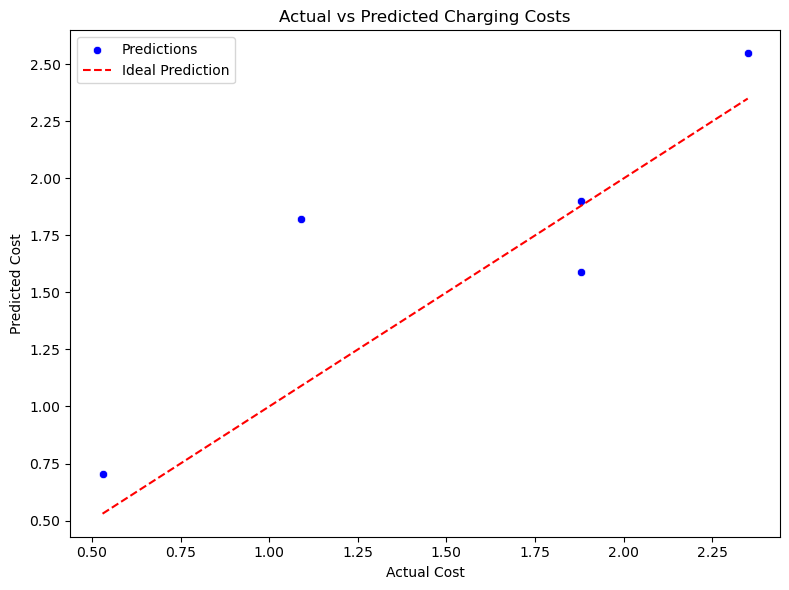

In [19]:
y_test_reset = pd.Series(y_test).reset_index(drop=True)
preds_reset = pd.Series(preds).reset_index(drop=True)

# Create a DataFrame with aligned actual vs predicted
results_df = pd.DataFrame({
    'Actual Cost': y_test_reset,
    'Predicted Cost': preds_reset
})

# Plot
plt.figure(figsize=(8, 6))
sb.scatterplot(data=results_df, x='Actual Cost', y='Predicted Cost', label='Predictions', color='blue')
plt.plot([results_df['Actual Cost'].min(), results_df['Actual Cost'].max()],
         [results_df['Actual Cost'].min(), results_df['Actual Cost'].max()],
         'r--', label='Ideal Prediction')

plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("Actual vs Predicted Charging Costs")
plt.legend()
plt.tight_layout()
plt.show()

R² Score: -0.6606429953726976
RMSE: 0.7336933280454466


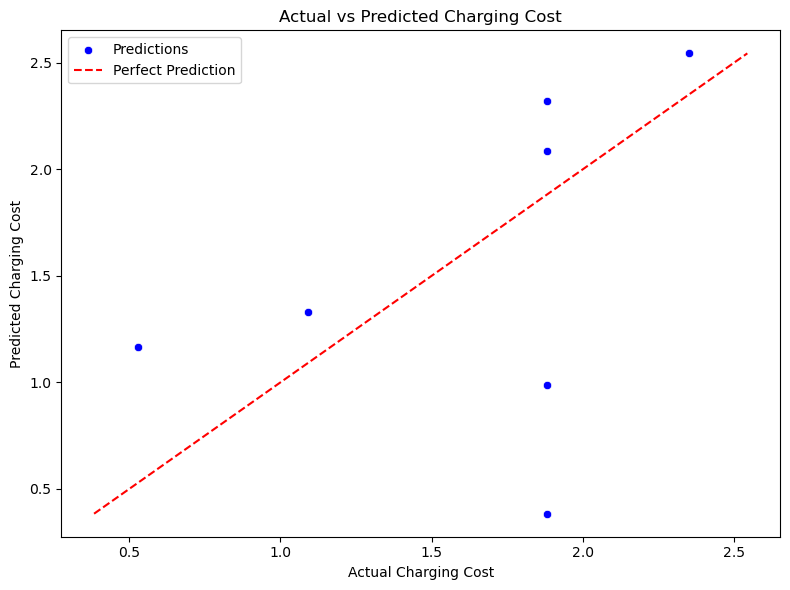

In [20]:
charging_data['date'] = pd.to_datetime(charging_data['date'])
driving_data['date'] = pd.to_datetime(driving_data['date'])

charging_data['hour'] = pd.to_datetime(charging_data['charge_time'], format='%H:%M:%S', errors='coerce').dt.hour
charging_data['day_of_week'] = charging_data['date'].dt.dayofweek

daily_trips = driving_data.groupby('date').agg({
    'miles': 'sum',
    'average_m/kwh': 'mean',
    'trip_cost': 'sum'
}).reset_index()

combined_df = pd.merge(charging_data, daily_trips, on='date', how='left')

combined_df.fillna(0, inplace=True)

encoder = OneHotEncoder(sparse_output=False)
encoded_places = encoder.fit_transform(combined_df[['charge_place']])
encoded_df = pd.DataFrame(encoded_places, columns=encoder.get_feature_names_out(['charge_place']))
combined_df = pd.concat([combined_df, encoded_df], axis=1)


features = combined_df[['day_of_week', 'hour', 'miles', 'average_m/kwh', 'trip_cost'] + list(encoded_df.columns)]
target = combined_df['cost']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", rmse)

results_df = pd.DataFrame({
    'Actual Cost': y_test.reset_index(drop=True),
    'Predicted Cost': pd.Series(y_pred)
})

# Seaborn plot
plt.figure(figsize=(8, 6))
sb.scatterplot(data=results_df, x='Actual Cost', y='Predicted Cost', label='Predictions', color='blue')

# Add ideal prediction line
min_val = min(results_df['Actual Cost'].min(), results_df['Predicted Cost'].min())
max_val = max(results_df['Actual Cost'].max(), results_df['Predicted Cost'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Charging Cost")
plt.ylabel("Predicted Charging Cost")
plt.title("Actual vs Predicted Charging Cost")
plt.legend()
plt.tight_layout()
plt.show()

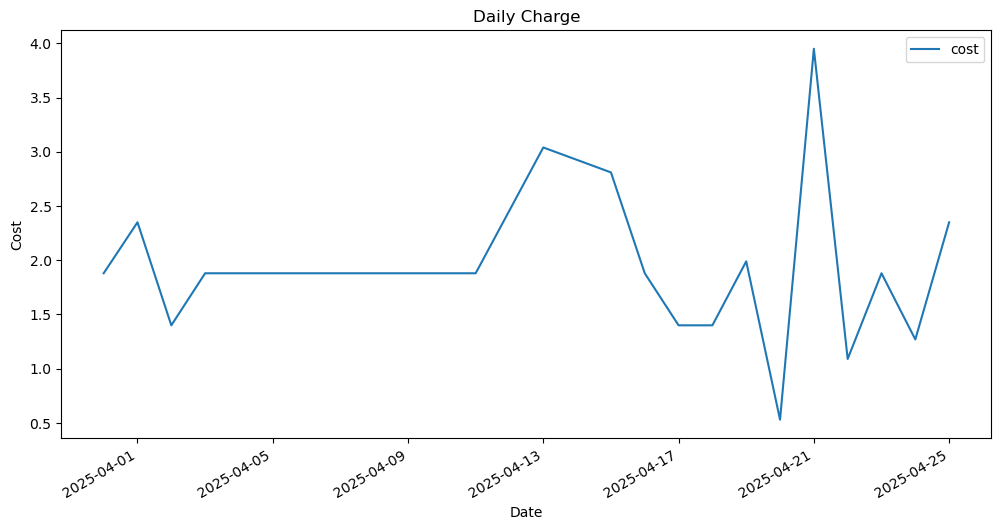

In [22]:
#charting it all up to prepare for prophet
charging_data['date'] = pd.to_datetime(charging_data['date'])

daily_charge = charging_data.groupby(charging_data['date'].dt.date)['cost'].sum().reset_index()
daily_charge['date'] = pd.to_datetime(daily_charge['date'])
daily_charge.set_index('date', inplace=True)

daily_charge['cost'].plot(figsize=(12,6), title= 'Daily Charge')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.legend()
plt.show()

12:20:36 - cmdstanpy - INFO - Chain [1] start processing
12:20:37 - cmdstanpy - INFO - Chain [1] done processing


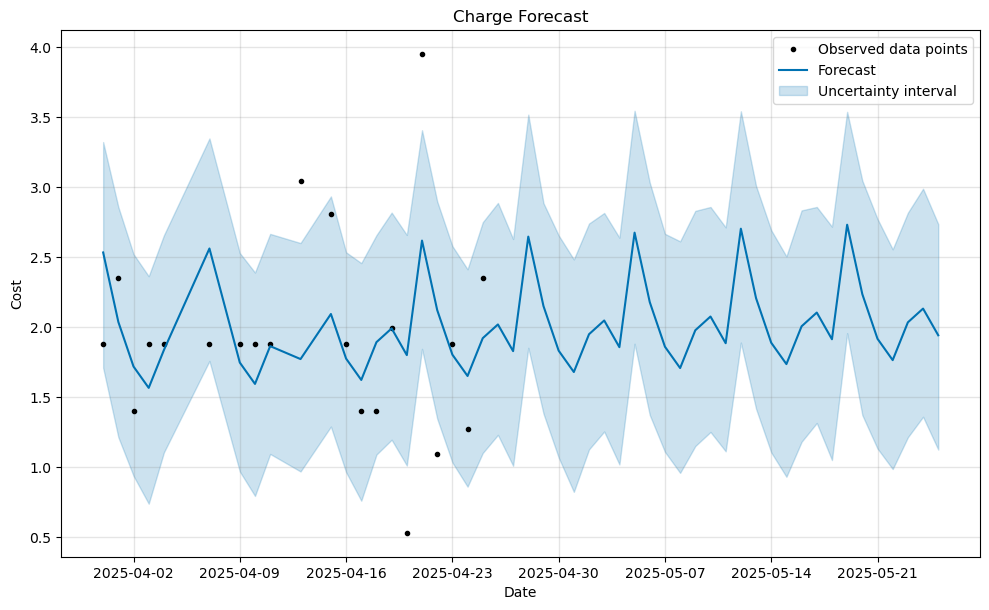

In [23]:
#doing all the prophet
cd = daily_charge.reset_index().rename(columns={'date': 'ds', 'cost': 'y'})

model= Prophet(stan_backend='CMDSTANPY')
model.fit(cd)

future= model.make_future_dataframe(periods=30)
forecast= model.predict(future)

model.plot(forecast)
plt.title("Charge Forecast")
plt.xlabel("Date")
plt.ylabel("Cost")
plt.legend()
plt.show()

## This is the graph of the cost of charging and the projected costs

In [24]:
#math so I don't have to figure out the average on my own. 
avg = driving_data['average_m/kwh'].mean()

print(avg)

4.894117647058823


In [25]:
with open('api_key.txt', 'r') as file:
    api_key = file.read().strip()

## HIDE THAT API

In [26]:
#total kwh is my battery and the rest is figured out in math.
total_kwh = 30  
efficiency_miles_per_kWh = avg  

#folium needs distance in meters and not miles
range_miles = total_kwh * efficiency_miles_per_kWh
range_meters = range_miles * 1609.34  

#coordinates to starting location (static)
ev_coords = (28.65106773376465, -81.33721923828125)

#creates map centered on my location chosen
m = folium.Map(location=ev_coords, zoom_start=6.5)

#add the marker to the map, and the icon is a cute car
folium.Marker(
    location=ev_coords,
    popup="Your EV Location",
    tooltip="EV Location",
    icon=folium.Icon(color="gray", icon="car", prefix="fa")
).add_to(m)

#the range based on my data
folium.Circle(
    location=ev_coords,
    radius=range_meters,
    color='blue',
    fill=True,
    fill_opacity=0.1,
    popup=f"Estimated Driving Range ({range_miles:.1f} miles)"
).add_to(m)

def is_near_edge(ev_coords, station_coords, max_range_miles, buffer=5):
    distance = geodesic(ev_coords, station_coords).miles
    return (max_range_miles - buffer) <= distance <= max_range_miles

#ADDING API *add airhorn emoji*
api_url = "https://api.openchargemap.io/v3/poi/"
params = {
    "output": "json",
    "latitude": ev_coords[0],
    "longitude": ev_coords[1],
    "distance": range_miles,
    "distanceunit": "Miles",
    "compact": True,
    "verbose": False,
    "key": api_key,
    "maxresults": 2000
}

response = requests.get(api_url, params=params)

# add some error detecting
try:
    stations = response.json()
except ValueError:
    print("JSON decoding failed. Response:", response.text)
    stations = []

# adding stations near the edge with a little warning that it might be too late.
for station in stations:
    coords = (
        station['AddressInfo']['Latitude'],
        station['AddressInfo']['Longitude']
    )
    name = station['AddressInfo']['Title']
    
    # Detect edge stations
    if is_near_edge(ev_coords, coords, range_miles, buffer=5):
        icon_color = "red"
        popup_text = f"⚠️ Edge Station: {name}"
    else:
        icon_color = "green"
        popup_text = f"Charging Station: {name}"

    folium.Marker(
        location=coords,
        popup=popup_text,
        icon=folium.Icon(color=icon_color, icon="bolt", prefix="fa")
    ).add_to(m)

# save the map
m.save("simple_ev_range_map.html")
m

## The map shows my current driving range on a full charge and all the charging stations within that range. The red ones are the ones that are close to the border.

In [27]:
#orange warning
buffer_zone = 10
#the beyone
outer_buffer = 15

# mapmapmap
m = folium.Map(location=ev_coords, zoom_start=6)

# marker
folium.Marker(
    location=ev_coords,
    popup="Your EV Location",
    tooltip="EV Location",
    icon=folium.Icon(color="gray", icon="car", prefix="fa")
).add_to(m)

# the raaaaange
folium.Circle(
    location=ev_coords,
    radius=range_meters,
    color='blue',
    fill=True,
    fill_opacity=0.1,
    popup=f"Estimated Driving Range ({range_miles:.1f} miles)"
).add_to(m)

# the toggle layers
green_layer = folium.FeatureGroup(name="✅ Within Range (Green)")
orange_layer = folium.FeatureGroup(name="⚠️ Near Edge (Orange)")
red_layer = folium.FeatureGroup(name="🚫 Outside Range (Red)")
gray_layer = folium.FeatureGroup(name="⬅️ Far Beyond Range (Gray)")

# openchargemap api settings
api_url = "https://api.openchargemap.io/v3/poi/"
params = {
    "output": "json",
    "latitude": ev_coords[0],
    "longitude": ev_coords[1],
    "distance": 1000,
    #"distance": range_miles + outer_buffer + 10,
    "distanceunit": "Miles",
    "compact": True,
    "verbose": False,
    "key": api_key,
    "maxresults": 3000
}

response = requests.get(api_url, params=params)

try:
    stations = response.json()
except ValueError:
    print("JSON decoding failed. Response:", response.text)
    stations = []

# gets the gps
for station in stations:
    coords = (
        station['AddressInfo']['Latitude'],
        station['AddressInfo']['Longitude']
    )
    name = station['AddressInfo']['Title']
    distance = geodesic(ev_coords, coords).miles

    if distance <= (range_miles - buffer_zone):
        # within the range
        folium.Marker(
            location=coords,
            popup=f"✅ Within Range: {name} ({distance:.1f} mi)",
            icon=folium.Icon(color="green", icon="bolt", prefix="fa")
        ).add_to(green_layer)

    elif (range_miles - buffer_zone) < distance <= range_miles:
        # getting close to the edge
        folium.Marker(
            location=coords,
            popup=f"⚠️ Near Edge: {name} ({distance:.1f} mi)",
            icon=folium.Icon(color="orange", icon="bolt", prefix="fa")
        ).add_to(orange_layer)

    elif range_miles < distance <= range_miles + outer_buffer:
        # at the edgs
        folium.Marker(
            location=coords,
            popup=f"🚫 Outside Range: {name} ({distance:.1f} mi)",
            icon=folium.Icon(color="red", icon="bolt", prefix="fa")
        ).add_to(red_layer)

    elif distance > range_miles + outer_buffer:
        # beyond the edgs
        folium.Marker(
            location=coords,
            popup=f"⬅️ Far Beyond Range: {name} ({distance:.1f} mi)",
            icon=folium.Icon(color="gray", icon="bolt", prefix="fa")
        ).add_to(gray_layer)

# adds the layers to the map
green_layer.add_to(m)
orange_layer.add_to(m)
red_layer.add_to(m)
gray_layer.add_to(m)

# adds the controls
folium.LayerControl(collapsed=False).add_to(m)

# save a show the map
m.save("ev_full_range_toggle_map.html")
m

## This is the map that shows everything in color codeing based on how close to the border I will be